In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge





In [2]:
data = pd.read_csv('/content/ks2_national_school_characteristics_2016_to_2023_provisional.csv')

In [ ]:
data.head()

In [ ]:
# choosing performance columns & creating composite scores as the avg of the columns
cols_for_composite_score = [
    'pt_gps_met_expected_standard',
    'pt_mat_met_expected_standard',
    'pt_read_met_expected_standard'
]

data[cols_for_composite_score] = data[cols_for_composite_score].apply(pd.to_numeric, errors='coerce')
data['composite_performance_score'] = data[cols_for_composite_score].mean(axis=1)

composite_score_preview = data[['composite_performance_score']].head()
composite_score_distribution = data['composite_performance_score'].describe()

composite_score_preview

In [ ]:
composite_score_distribution


In [5]:
# Choosing features for school characteristics & creating a target based on the composite score
school_characteristics = [
    'geographic_level', 'country_name', 'breakdown_topic', 'breakdown', 'school_type'
]

data[school_characteristics] = data[school_characteristics].fillna("Unknown")


In [6]:
data['performance_category'] = pd.qcut(data['composite_performance_score'],
                                       3, labels=['low', 'medium', 'high'])
data_cleaned = data.dropna(subset=['composite_performance_score'])


In [7]:
# encoding the categorical variables and splitting data for ML
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data_cleaned[school_characteristics])

X = encoded_features
y = data_cleaned['performance_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((228, 48), (99, 48), (228,), (99,))

## Function to evaluate model performance

In [8]:

def evaluate_and_print_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    classification_report_results = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:\n")
    for label, metrics in classification_report_results.items():
        if isinstance(metrics, dict):
            print(f"Class '{label}' Metrics:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.2f}")
        else:
            print(f"Accuracy: {metrics:.2f}")
        print()
# evaluate_and_print_classification_report(rf_classifier, X_test_cleaned, y_test_cleaned)


In [9]:
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [10]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)


In [ ]:
evaluate_and_print_classification_report(rf_classifier, X_test, y_test)

In [ ]:
# Extract feature importance from the Random Forest model
feature_importances = rf_classifier.feature_importances_

features_df = pd.DataFrame({
    'Feature': encoder.get_feature_names_out(school_characteristics),
    'Importance': feature_importances
})

sorted_features = features_df.sort_values(by='Importance', ascending=False)

sorted_features.head(10)


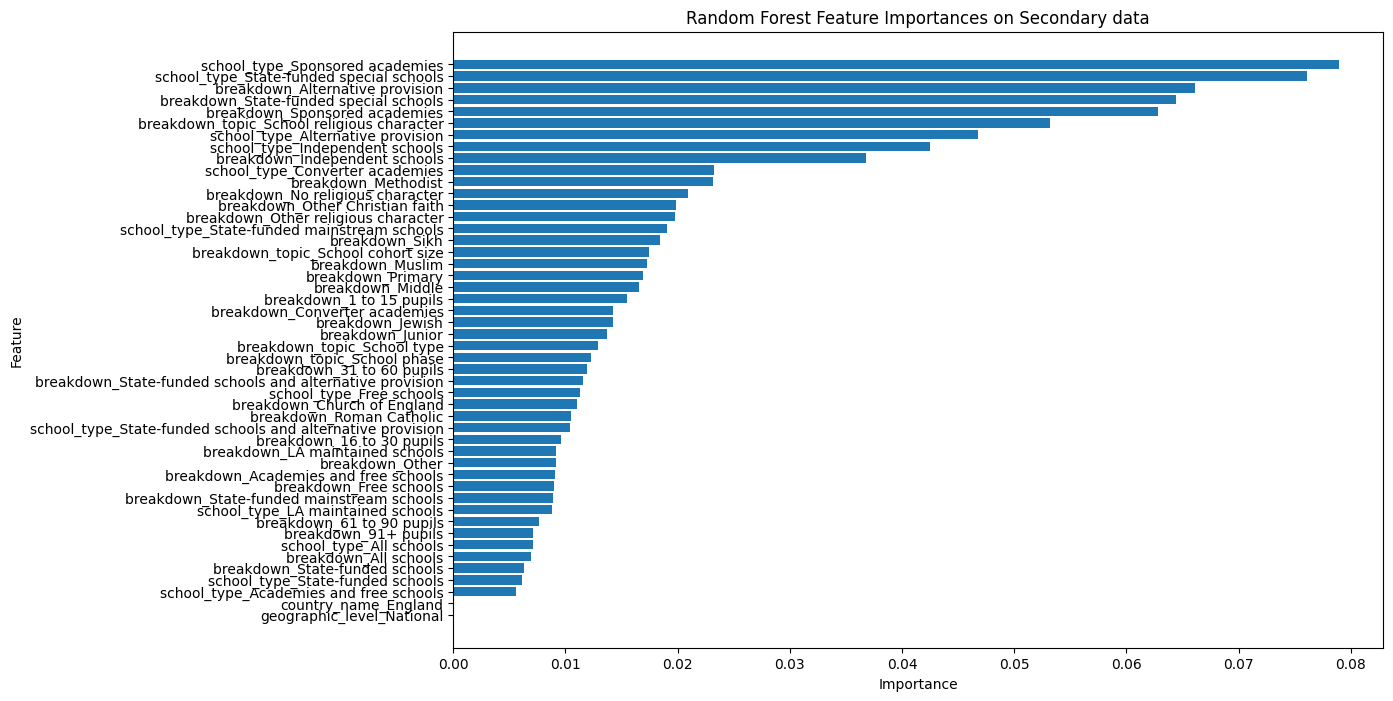

In [13]:
plt.figure(figsize=(12, 8))
plt.barh(sorted_features['Feature'], sorted_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances on Secondary data')
plt.gca().invert_yaxis()
plt.show()


In [14]:
# Selecting the top 10 features and retraining the model with it
top_features = sorted_features['Feature'].head(10)

top_feature_indices = [list(encoder.get_feature_names_out(school_characteristics)).index(feat) for feat in top_features]

X_refined = X[:, top_feature_indices]
X_train_refined, X_test_refined, y_train_refined, y_test_refined = train_test_split(
    X_refined, y, test_size=0.3, random_state=42
)

rf_classifier_refined = RandomForestClassifier(random_state=42)
rf_classifier_refined.fit(X_train_refined, y_train_refined)

# Predict on the refined test set
y_pred_refined = rf_classifier_refined.predict(X_test_refined)

# Evaluate the model with the refined data
#classification_report_results_refined = classification_report(y_test_refined, y_pred_refined)



In [15]:
X_train_refined.shape, X_test_refined.shape


((228, 10), (99, 10))

In [16]:
evaluate_and_print_classification_report(rf_classifier_refined, X_test_refined, y_test_refined)

Classification Report:

Class 'high' Metrics:
  precision: 0.67
  recall: 0.54
  f1-score: 0.60
  support: 26.00

Class 'low' Metrics:
  precision: 0.87
  recall: 0.41
  f1-score: 0.55
  support: 32.00

Class 'medium' Metrics:
  precision: 0.54
  recall: 0.83
  f1-score: 0.65
  support: 41.00

Accuracy: 0.62

Class 'macro avg' Metrics:
  precision: 0.69
  recall: 0.59
  f1-score: 0.60
  support: 99.00

Class 'weighted avg' Metrics:
  precision: 0.68
  recall: 0.62
  f1-score: 0.61
  support: 99.00



In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42,
                           class_weight='balanced'),
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [18]:
evaluate_and_print_classification_report(grid_search, X_test, y_test)
#Accuracy: 0.57

Classification Report:

Class 'high' Metrics:
  precision: 0.52
  recall: 0.54
  f1-score: 0.53
  support: 26.00

Class 'low' Metrics:
  precision: 0.87
  recall: 0.41
  f1-score: 0.55
  support: 32.00

Class 'medium' Metrics:
  precision: 0.51
  recall: 0.71
  f1-score: 0.59
  support: 41.00

Accuracy: 0.57

Class 'macro avg' Metrics:
  precision: 0.63
  recall: 0.55
  f1-score: 0.56
  support: 99.00

Class 'weighted avg' Metrics:
  precision: 0.63
  recall: 0.57
  f1-score: 0.56
  support: 99.00



## AdaBoost with RF as base

In [ ]:
base_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
ada_boost_rf = AdaBoostClassifier(estimator=base_rf, random_state=42, n_estimators=50)
ada_boost_rf.fit(X_train, y_train)


In [20]:
evaluate_model(ada_boost_rf, 'Random Forest', X_train, X_test, y_test)
#Random Forest Accuracy AdaBoost: 0.5353535353535354


Random Forest Accuracy: 0.5353535353535354
Random Forest Classification Report:
              precision    recall  f1-score   support

        high       0.52      0.54      0.53        26
         low       0.62      0.47      0.54        32
      medium       0.50      0.59      0.54        41

    accuracy                           0.54        99
   macro avg       0.55      0.53      0.53        99
weighted avg       0.55      0.54      0.54        99

Random Forest Prediction Probabilities (First 5 Predictions):
[[7.55632037e-02 7.27037325e-01 1.97399471e-01]
 [3.28541702e-01 3.32691144e-01 3.38767154e-01]
 [3.36229118e-01 3.24899647e-01 3.38871235e-01]
 [5.68482656e-01 4.83249046e-15 4.31517344e-01]
 [2.22044605e-16 1.00000000e+00 2.22044605e-16]]
--------------------------------------------------


In [21]:
# ada model pipeline
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
        random_state=42))
])


In [ ]:
param_dist_ada = {
    'ada_boost_rf__n_estimators': randint(5, 20),
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}
random_search_ada = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_dist_ada,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search_ada.fit(X_train, y_train)


In [23]:
evaluate_model(random_search_ada, 'AdaBoost with RF', X_train, X_test, y_test)


AdaBoost with RF Accuracy: 0.5353535353535354
AdaBoost with RF Classification Report:
              precision    recall  f1-score   support

        high       0.52      0.54      0.53        26
         low       0.62      0.47      0.54        32
      medium       0.50      0.59      0.54        41

    accuracy                           0.54        99
   macro avg       0.55      0.53      0.53        99
weighted avg       0.55      0.54      0.54        99

AdaBoost with RF Prediction Probabilities (First 5 Predictions):
[[9.03697432e-02 6.98699145e-01 2.10931112e-01]
 [2.66396877e-01 2.74788634e-01 4.58814489e-01]
 [3.68221631e-01 1.42177245e-01 4.89601124e-01]
 [5.74214419e-01 8.81056205e-14 4.25785581e-01]
 [2.22044605e-16 1.00000000e+00 2.22044605e-16]]
--------------------------------------------------


## Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)


In [25]:
evaluate_model(logreg, 'Logistic Regression', X_train, X_test, y_test)


Logistic Regression Accuracy: 0.5454545454545454
Logistic Regression Classification Report:
              precision    recall  f1-score   support

        high       0.54      0.54      0.54        26
         low       0.62      0.47      0.54        32
      medium       0.51      0.61      0.56        41

    accuracy                           0.55        99
   macro avg       0.56      0.54      0.54        99
weighted avg       0.55      0.55      0.54        99

Logistic Regression Prediction Probabilities (First 5 Predictions):
[[0.17586977 0.49173065 0.33239957]
 [0.23633325 0.25756999 0.50609677]
 [0.35364888 0.14120291 0.5051482 ]
 [0.57497585 0.08008462 0.34493954]
 [0.03527771 0.92846236 0.03625993]]
--------------------------------------------------


In [ ]:
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)


In [27]:
evaluate_model(svm_classifier, 'svm ', X_train, X_test, y_test)


svm  Accuracy: 0.5656565656565656
svm  Classification Report:
              precision    recall  f1-score   support

        high       0.52      0.54      0.53        26
         low       0.87      0.41      0.55        32
      medium       0.51      0.71      0.59        41

    accuracy                           0.57        99
   macro avg       0.63      0.55      0.56        99
weighted avg       0.63      0.57      0.56        99

svm  Prediction Probabilities (First 5 Predictions):
[[0.21772463 0.42204464 0.36023073]
 [0.25016166 0.2953064  0.45453194]
 [0.3473605  0.18446553 0.46817397]
 [0.58308495 0.16686901 0.25004604]
 [0.16414446 0.65426716 0.18158838]]
--------------------------------------------------


## function to return full array of predictions

In [28]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [29]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:",{best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [30]:
# collecting the data
y_test1, y_pred1, y_pred_prob1 = get_model_pred(rf_classifier_refined, X_test_refined, y_test_refined)
y_test_gs1, y_pred_gs1, y_pred_prob_gs1 = get_model_pred(svm_classifier, X_test, y_test)
y_test_gs2, y_pred_gs2, y_pred_prob_gs2 = get_model_pred(logreg, X_test, y_test)

Accuracy: 0.6161616161616161
Classification Report:
              precision    recall  f1-score   support

        high       0.67      0.54      0.60        26
         low       0.87      0.41      0.55        32
      medium       0.54      0.83      0.65        41

    accuracy                           0.62        99
   macro avg       0.69      0.59      0.60        99
weighted avg       0.68      0.62      0.61        99

Accuracy: 0.5656565656565656
Classification Report:
              precision    recall  f1-score   support

        high       0.52      0.54      0.53        26
         low       0.87      0.41      0.55        32
      medium       0.51      0.71      0.59        41

    accuracy                           0.57        99
   macro avg       0.63      0.55      0.56        99
weighted avg       0.63      0.57      0.56        99

Accuracy: 0.5454545454545454
Classification Report:
              precision    recall  f1-score   support

        high       0.54    

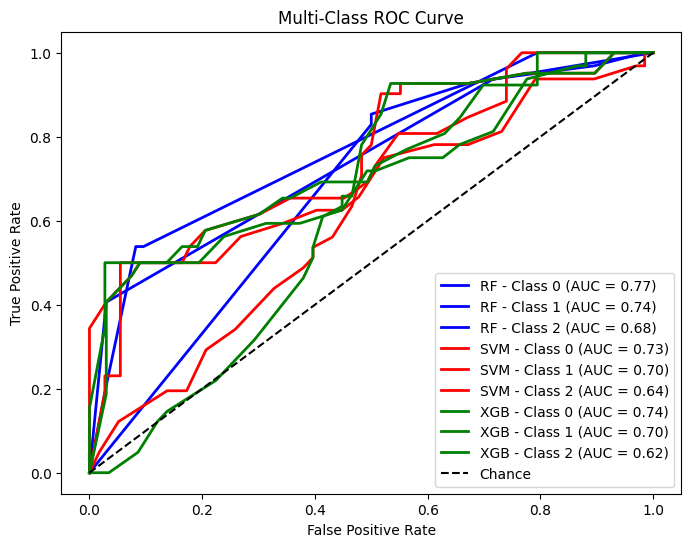

In [31]:
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Function to plot ROC curve for each class
def plot_multiclass_roc(y_true, y_pred_prob, n_classes, model_label, color):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_label} - Class {i} (AUC = {roc_auc[i]:.2f})')

color_cycle = cycle(['blue', 'red', 'green'])

plt.figure(figsize=(8, 6))
plot_multiclass_roc(y_test_binarized, y_pred_prob1, n_classes, 'RF', next(color_cycle))
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes, 'SVM', next(color_cycle))
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs2, n_classes, 'XGB', next(color_cycle))

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


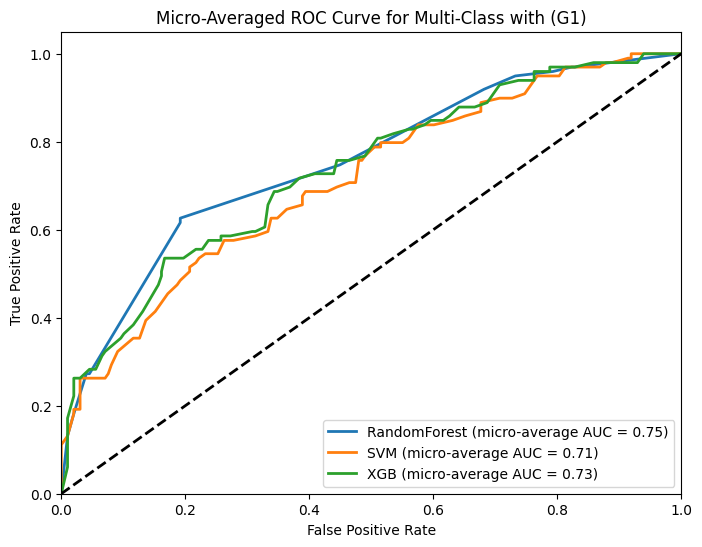

In [32]:
# Function to plot ROC curve for each model with micro-averaging
def plot_micro_averaged_roc_curve(y_true, y_score, n_classes, ax, name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"],
            label=f'{name} (micro-average AUC = {roc_auc["micro"]:0.2f})',
            linestyle='-', linewidth=2)


fig, ax = plt.subplots(figsize=(8, 6))
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'RandomForest')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'SVM')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'XGB')
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-Averaged ROC Curve for Multi-Class with (G1)')
ax.legend(loc="lower right")
plt.show()

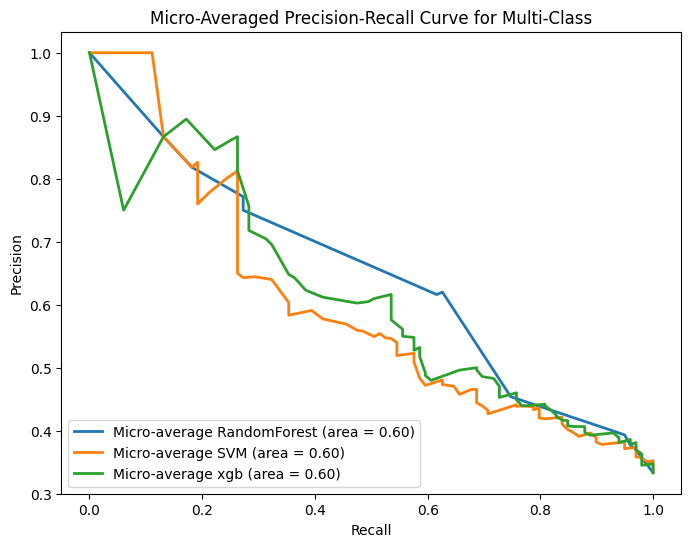

In [33]:
# Function to plot Precision-Recall curve for each model with micro-averaging
def plot_micro_averaged_precision_recall_curve(y_true, y_score, n_classes, ax, name):
    precision = dict()
    recall = dict()
    average_precision = dict()

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_score, average="micro")

    ax.plot(recall["micro"], precision["micro"], lw=2,
             label=f'Micro-average {name} (area = {average_precision["micro"]:0.2f})')

fig, ax = plt.subplots(figsize=(8, 6))
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'RandomForest')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'SVM')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'xgb')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Micro-Averaged Precision-Recall Curve for Multi-Class')
ax.legend(loc="lower left")
plt.show()

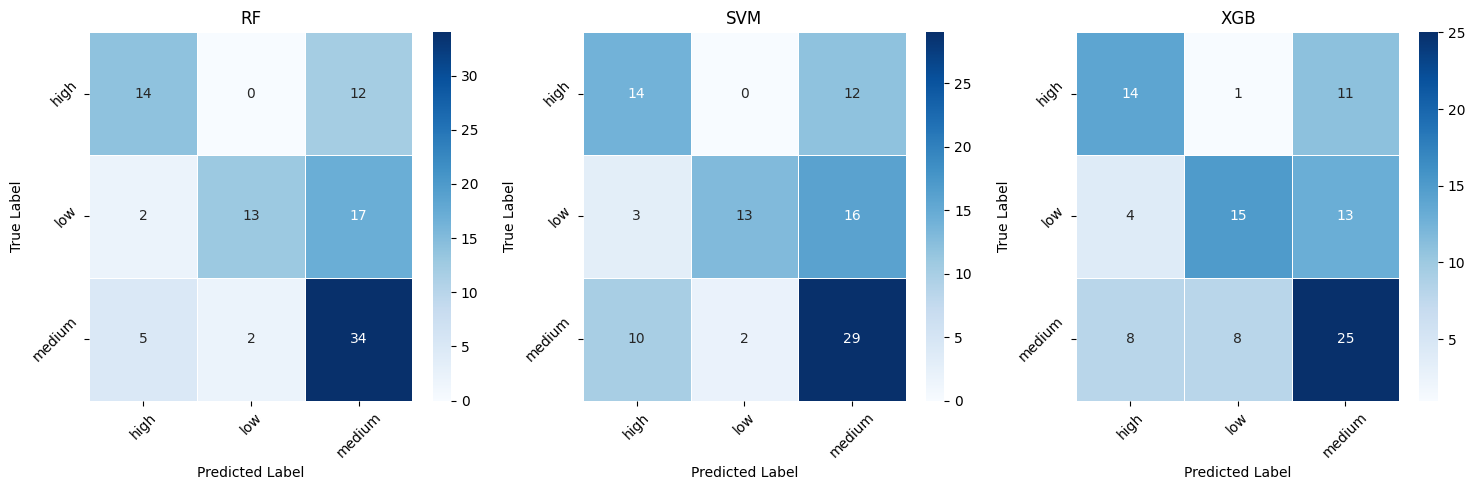

In [34]:

# Function to plot the confusion matrix of best models
def plot_confusion_matrix(cm, classes, title, ax, cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax, cmap=cmap)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
class_labels = np.unique(y_test)
predictions = [
    (y_test1, y_pred1, 'RF'),
    (y_test_gs1, y_pred_gs1, 'SVM'),
    (y_test_gs2, y_pred_gs2, 'XGB'),
]

for i, (y_test, y_pred, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i]
    plot_confusion_matrix(cm, class_labels, title, ax)

plt.tight_layout()
plt.show()


## Regression model implementation

In [ ]:
# Random forest regressor model
y_regression = data_cleaned['composite_performance_score']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_refined, y_regression, test_size=0.3, random_state=42
)

rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = rf_regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

mse, r2

(101.74998714287347, 0.8111965135832326)

In [ ]:

# Gradient boosting
gb_regressor = GradientBoostingRegressor(random_state=42)
lr_regressor = LinearRegression()
ridge_regressor = Ridge(random_state=42)

gb_regressor.fit(X_train_reg, y_train_reg)
y_pred_gb = gb_regressor.predict(X_test_reg)
mse_gb = mean_squared_error(y_test_reg, y_pred_gb)
r2_gb = r2_score(y_test_reg, y_pred_gb)

(mse_gb, r2_gb)


((101.98959772444921, 0.8107519011124681),
 (146.0794256852755, 0.7289404584944872),
 (102.10851699924719, 0.8105312389353566))

In [ ]:
#Linear Regression
lr_regressor.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_regressor.predict(X_test_reg)
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)
(mse_lr, r2_lr)


In [ ]:
# Ridge Regression
ridge_regressor.fit(X_train_reg, y_train_reg)
y_pred_ridge = ridge_regressor.predict(X_test_reg)
mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)
(mse_ridge, r2_ridge)

In [ ]:
# Extract feature importance from the Gradient Boosting Regressor
gb_feature_importances = gb_regressor.feature_importances_
gb_features_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': gb_feature_importances
})

sorted_gb_features = gb_features_df.sort_values(by='Importance', ascending=False)

sorted_gb_features.head(10)

,Feature,Importance
47,school_type_State-funded special schools,0.295547
35,breakdown_State-funded special schools,0.285329
38,school_type_Alternative provision,0.240761
13,breakdown_Alternative provision,0.154185
4,breakdown_topic_School religious character,0.010537
31,breakdown_Sponsored academies,0.004424
43,school_type_Sponsored academies,0.003210
17,breakdown_Independent schools,0.002203
39,school_type_Converter academies,0.002142
41,school_type_Independent schools,0.001663


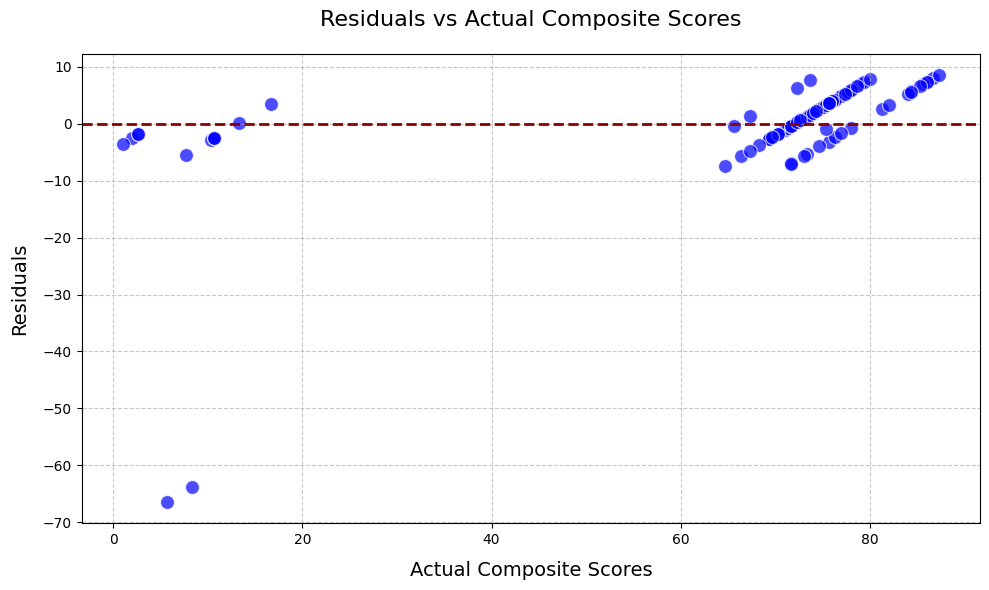

In [ ]:
# Calculate residuals (difference between actual and predicted values)
residuals = y_test_reg - y_pred_ridge

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=residuals, color='blue', edgecolor='w', s=100, alpha=0.7)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2)

plt.xlabel('Actual Composite Scores', fontsize=14, labelpad=10)
plt.ylabel('Residuals', fontsize=14, labelpad=10)
plt.title('Residuals vs Actual Composite Scores', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
# Creating a DF for comparing actual vs predicted composite scores
comparison_df = pd.DataFrame({
    'Actual Score': y_test_reg,
    'Predicted Score': y_pred_gb,
    'Residual': residuals
})
comparison_sample = comparison_df.sample(10)
comparison_sample


,Actual Score,Predicted Score,Residual
103,77.000000,72.528024,4.900872
134,10.666667,10.544472,-2.526049
160,1.000000,2.167975,-3.555142
148,72.333333,65.834973,6.306927
199,87.333333,79.091083,8.517429
197,75.666667,72.528024,3.567539
363,79.000000,72.528024,6.900872
7,64.666667,72.528024,-7.432461
3,70.333333,72.528024,-1.765794
126,73.666667,72.528024,1.567539


<ipython-input-53-a401804df7ed>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=comparison_df['Actual Score'], label='Actual Score', shade=True)
<ipython-input-53-a401804df7ed>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=comparison_df['Predicted Score'], label='Predicted Score', shade=True)


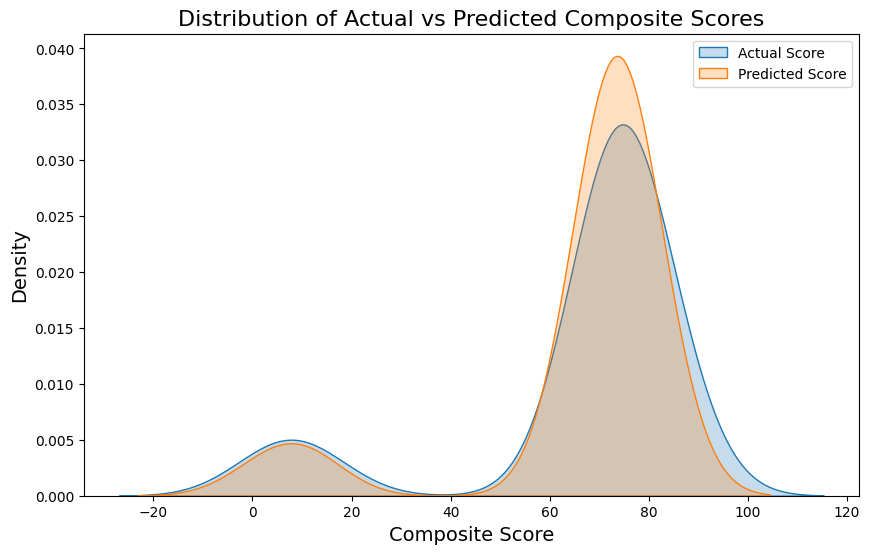

In [ ]:
comparison_df = pd.DataFrame({
    'Actual Score': y_test_reg,
    'Predicted Score': y_pred_gb,
})
plt.figure(figsize=(10, 6))
sns.kdeplot(data=comparison_df['Actual Score'], label='Actual Score', fill=True)
sns.kdeplot(data=comparison_df['Predicted Score'], label='Predicted Score', fill=True)
plt.xlabel('Composite Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Actual vs Predicted Composite Scores', fontsize=16)
plt.legend()
plt.show()
